In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "rbc_phase"
ood = "0"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

RBC Dataset V.2 => All pateints
Dataset split type train, image type: phase


Loaded 2752 images
RBC Dataset V.2 => All pateints
Dataset split type val, image type: phase


Loaded 928 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 928 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 493 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0 sqy0ovuk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/43 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                | 1/43 [00:00<00:37,  1.11it/s]

  7%|██████████▎                                                                                                                                         | 3/43 [00:01<00:12,  3.31it/s]

 12%|█████████████████▏                                                                                                                                  | 5/43 [00:01<00:07,  5.16it/s]

 16%|████████████████████████                                                                                                                            | 7/43 [00:01<00:05,  6.62it/s]

 21%|██████████████████████████████▉                                                                                                                     | 9/43 [00:01<00:04,  7.76it/s]

 26%|█████████████████████████████████████▌                                                                                                             | 11/43 [00:01<00:03,  8.61it/s]

 30%|████████████████████████████████████████████▍                                                                                                      | 13/43 [00:02<00:03,  9.24it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 15/43 [00:02<00:02,  9.69it/s]

 40%|██████████████████████████████████████████████████████████                                                                                         | 17/43 [00:02<00:02, 10.03it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 19/43 [00:02<00:02, 10.27it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 21/43 [00:02<00:02, 10.43it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 23/43 [00:02<00:01, 10.55it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 25/43 [00:03<00:01, 10.62it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 27/43 [00:03<00:01, 10.68it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 29/43 [00:03<00:01, 10.71it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 31/43 [00:03<00:01, 10.76it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 33/43 [00:03<00:00, 10.77it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 35/43 [00:04<00:00, 10.79it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 37/43 [00:04<00:00, 10.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 39/43 [00:04<00:00, 10.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 41/43 [00:04<00:00, 10.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:04<00:00, 10.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:04<00:00,  8.95it/s]

train - OK


  0%|                                                                                                                                                            | 0/15 [00:00<?, ?it/s]

  7%|█████████▊                                                                                                                                          | 1/15 [00:00<00:03,  3.71it/s]

 20%|█████████████████████████████▌                                                                                                                      | 3/15 [00:00<00:01,  7.23it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 5/15 [00:00<00:01,  8.71it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                               | 7/15 [00:00<00:00,  9.49it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 9/15 [00:01<00:00,  9.96it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 11/15 [00:01<00:00, 10.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 13/15 [00:01<00:00, 10.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.49it/s]

val - OK


  0%|                                                                                                                                                            | 0/15 [00:00<?, ?it/s]

  7%|█████████▊                                                                                                                                          | 1/15 [00:00<00:03,  3.75it/s]

 20%|█████████████████████████████▌                                                                                                                      | 3/15 [00:00<00:01,  7.28it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 5/15 [00:00<00:01,  8.75it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                               | 7/15 [00:00<00:00,  9.55it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 9/15 [00:01<00:00, 10.02it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 11/15 [00:01<00:00, 10.31it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 13/15 [00:01<00:00, 10.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.69it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/8 [00:00<?, ?it/s]

 12%|██████████████████▋                                                                                                                                  | 1/8 [00:00<00:01,  3.69it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                             | 3/8 [00:00<00:00,  7.21it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 5/8 [00:00<00:00,  8.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 7/8 [00:00<00:00,  9.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.40it/s]

test OoD - OK


  0%|                                                                                                                                                           | 0/100 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                | 2/100 [00:00<00:08, 12.22it/s]

  4%|█████▉                                                                                                                                             | 4/100 [00:00<00:07, 12.25it/s]

  6%|████████▊                                                                                                                                          | 6/100 [00:00<00:07, 12.26it/s]

  8%|███████████▊                                                                                                                                       | 8/100 [00:00<00:07, 12.27it/s]

 10%|██████████████▌                                                                                                                                   | 10/100 [00:00<00:07, 12.28it/s]

 12%|█████████████████▌                                                                                                                                | 12/100 [00:00<00:07, 12.29it/s]

 14%|████████████████████▍                                                                                                                             | 14/100 [00:01<00:06, 12.29it/s]

 16%|███████████████████████▎                                                                                                                          | 16/100 [00:01<00:06, 12.29it/s]

 18%|██████████████████████████▎                                                                                                                       | 18/100 [00:01<00:06, 12.29it/s]

 20%|█████████████████████████████▏                                                                                                                    | 20/100 [00:01<00:06, 12.29it/s]

 22%|████████████████████████████████                                                                                                                  | 22/100 [00:01<00:06, 12.29it/s]

 24%|███████████████████████████████████                                                                                                               | 24/100 [00:01<00:06, 12.29it/s]

 26%|█████████████████████████████████████▉                                                                                                            | 26/100 [00:02<00:06, 12.29it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 28/100 [00:02<00:05, 12.30it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 30/100 [00:02<00:05, 12.30it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 32/100 [00:02<00:05, 12.26it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 34/100 [00:02<00:05, 12.27it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 36/100 [00:02<00:05, 12.28it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 38/100 [00:03<00:05, 12.29it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 40/100 [00:03<00:04, 12.29it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 42/100 [00:03<00:04, 12.29it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 44/100 [00:03<00:04, 12.29it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 46/100 [00:03<00:04, 12.30it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                            | 48/100 [00:03<00:04, 12.25it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 50/100 [00:04<00:04, 12.26it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 52/100 [00:04<00:03, 12.27it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 54/100 [00:04<00:03, 12.28it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 56/100 [00:04<00:03, 12.29it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 58/100 [00:04<00:03, 12.29it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 60/100 [00:04<00:03, 12.29it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 62/100 [00:05<00:03, 12.30it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 64/100 [00:05<00:02, 12.29it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 66/100 [00:05<00:02, 12.30it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 68/100 [00:05<00:02, 12.30it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 70/100 [00:05<00:02, 12.30it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 72/100 [00:05<00:02, 12.30it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 74/100 [00:06<00:02, 12.30it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 76/100 [00:06<00:01, 12.30it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 78/100 [00:06<00:01, 12.30it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 80/100 [00:06<00:01, 12.30it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 82/100 [00:06<00:01, 12.30it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 84/100 [00:06<00:01, 12.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 86/100 [00:06<00:01, 12.30it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 88/100 [00:07<00:00, 12.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 90/100 [00:07<00:00, 12.30it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 92/100 [00:07<00:00, 12.30it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:07<00:00, 12.30it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:07<00:00, 12.30it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:07<00:00, 12.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.29it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(2752, 1, 64, 64) (2752, 512) (2752, 3584) (2752, 1, 64, 64) (2752,)
(928, 1, 64, 64) (928, 512) (928, 3584) (928, 1, 64, 64) (928,)
(928, 1, 64, 64) (928, 512) (928, 3584) (928, 1, 64, 64) (928,)
(493, 1, 64, 64) (493, 512) (493, 3584) (493, 1, 64, 64) (493,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

WARNING clustering 1421 points to 37 centroids: please provide at least 1443 training points


(928, 2) (493, 2)


WARNING clustering 1421 points to 37 centroids: please provide at least 1443 training points


(928, 2) (493, 2)


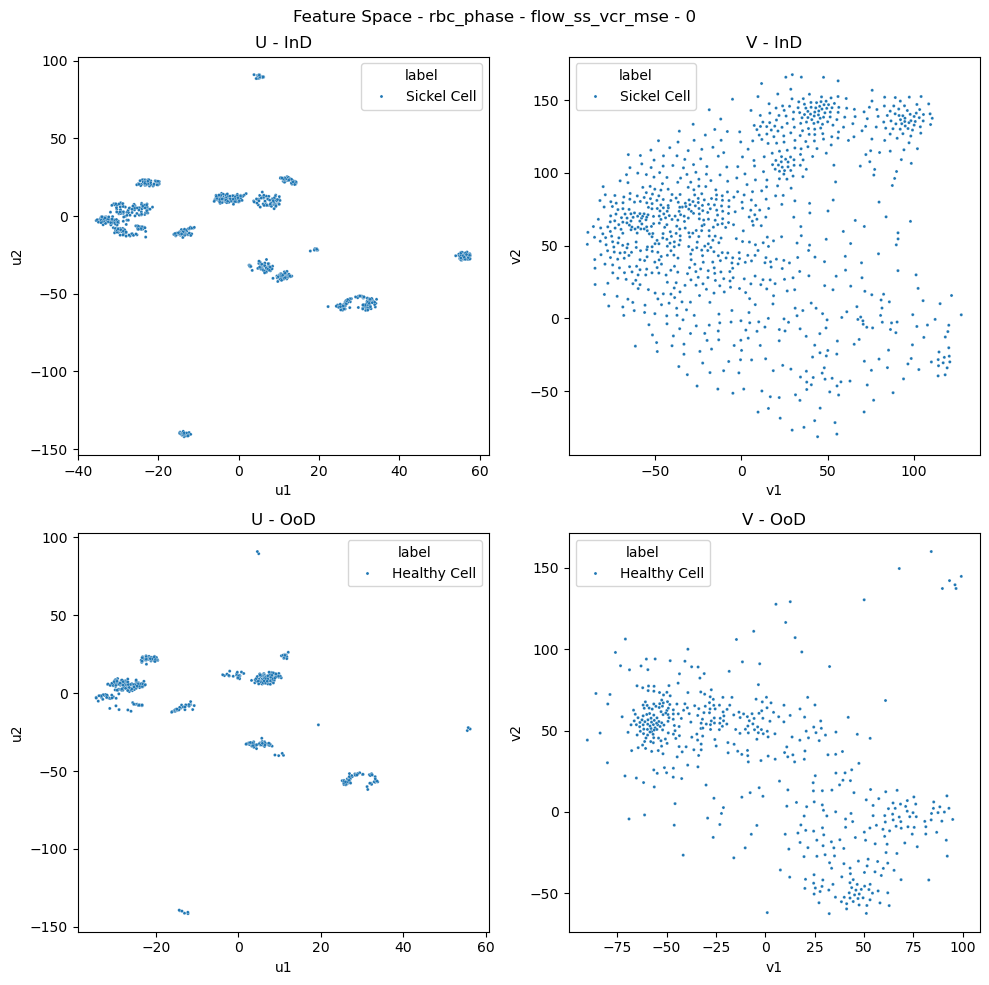

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:00<00:00,  7.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:00<00:00,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:00<00:00,  5.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.96it/s]

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:00<00:00,  5.59it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:00<00:00,  5.63it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:00<00:00,  5.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.55it/s]

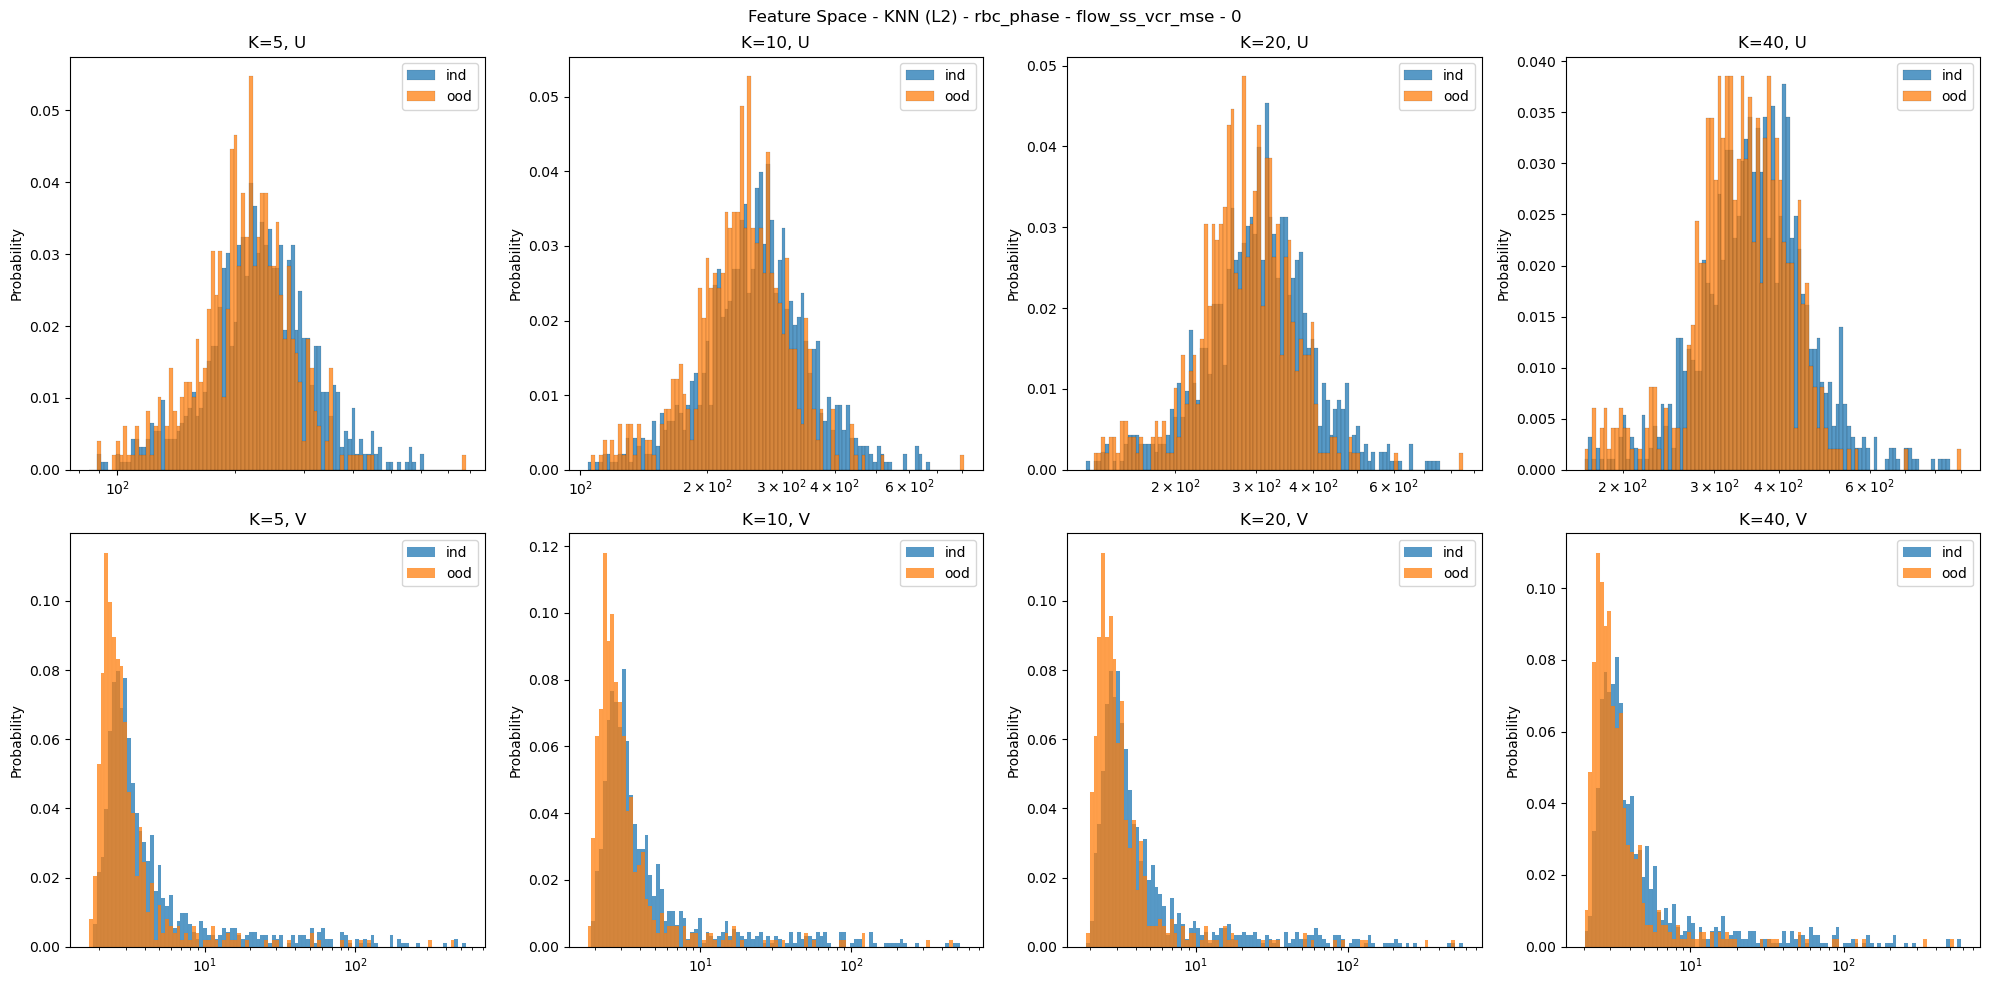

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:00<00:00,  8.31it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:00<00:00,  8.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:00<00:00,  8.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:00<00:00,  5.72it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:00<00:00,  5.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:00<00:00,  5.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  3.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.48it/s]

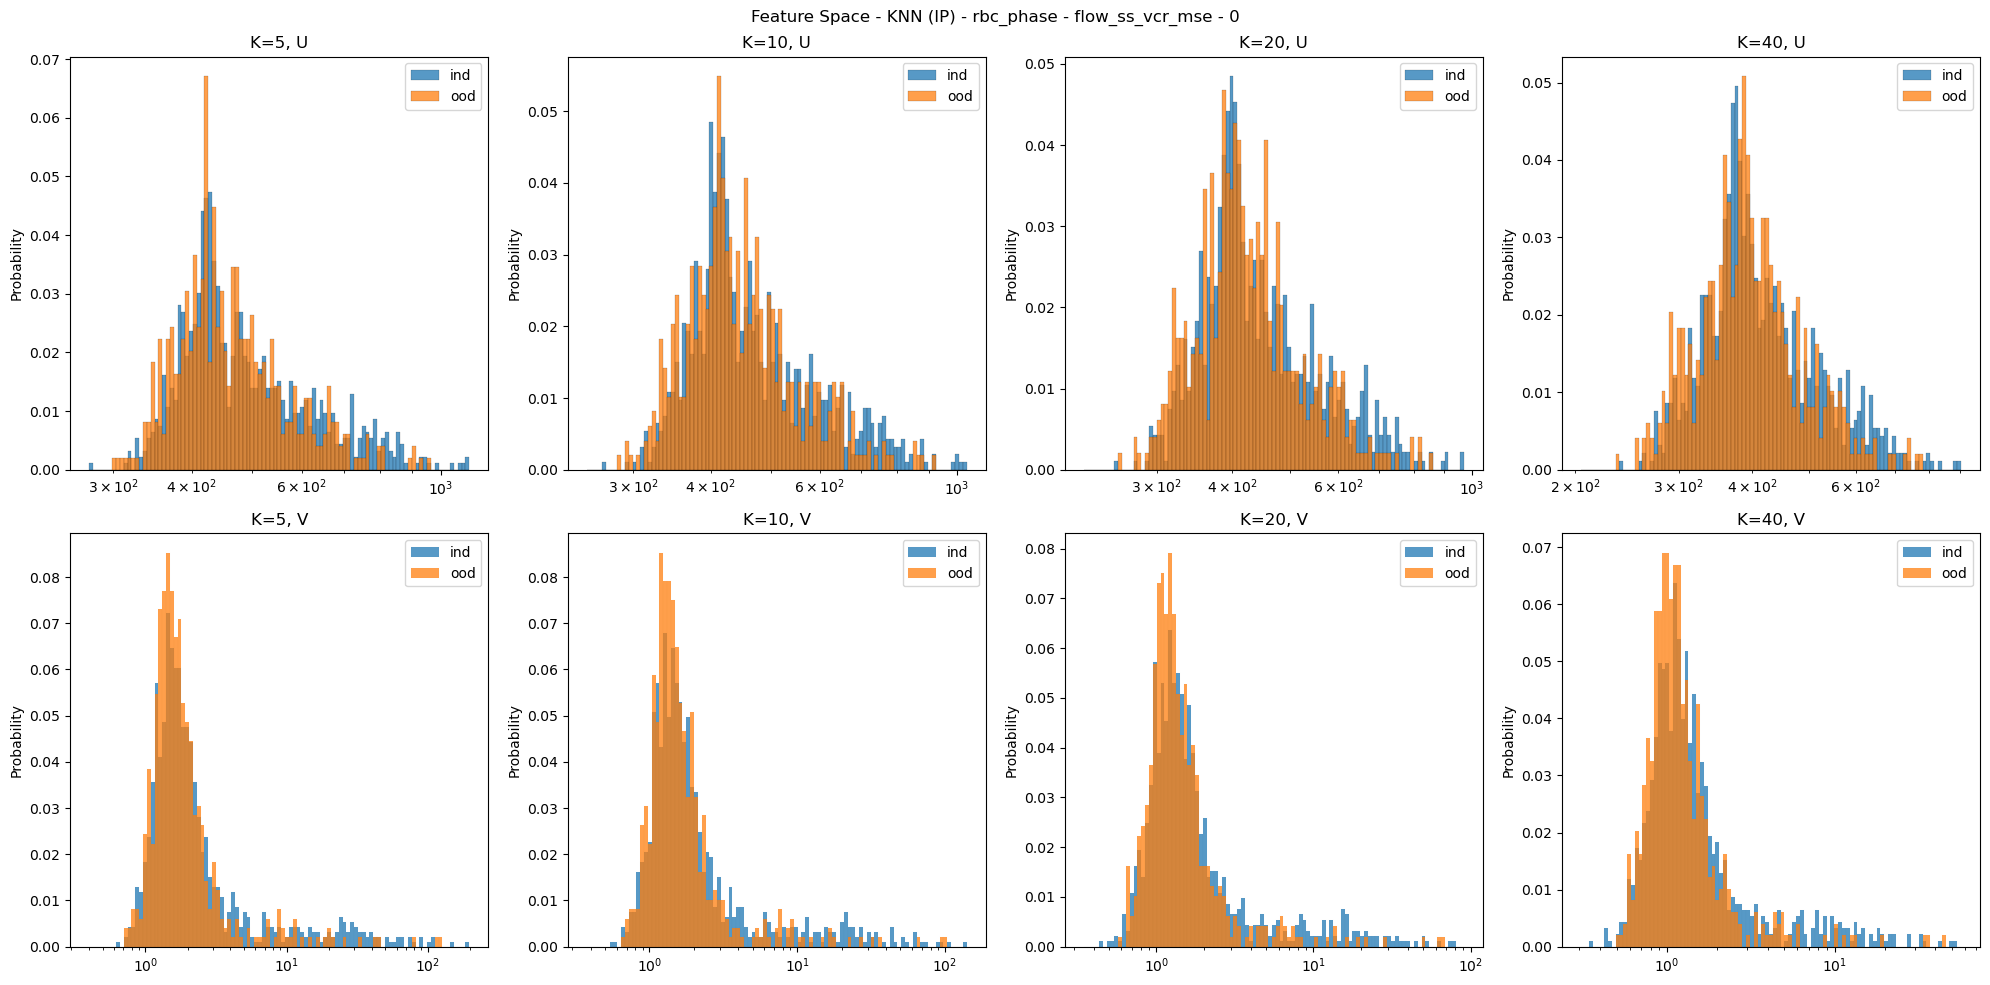

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

24.3701 2.8798559 2.5127287 2.5031583
24.230322 2.6850636 2.3848803 2.046904
24.394066 2.8679307 2.5087 2.51757
23.553234 2.0179136 1.8752241 1.6495594
32.27845 0.80999243 50.253014 0.6611115


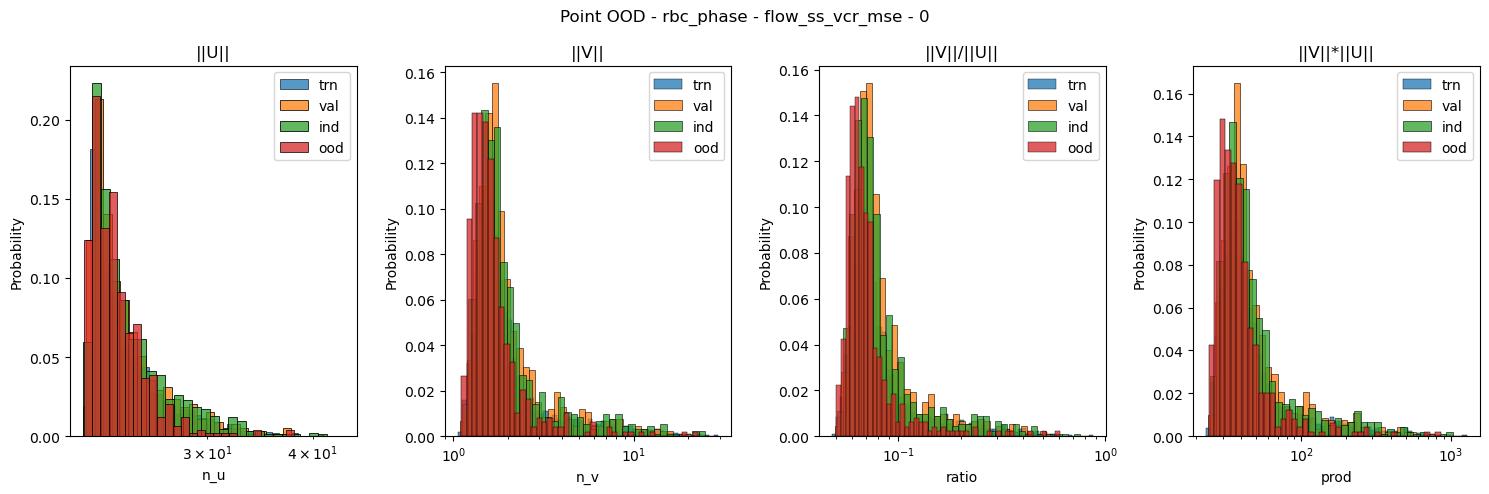

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


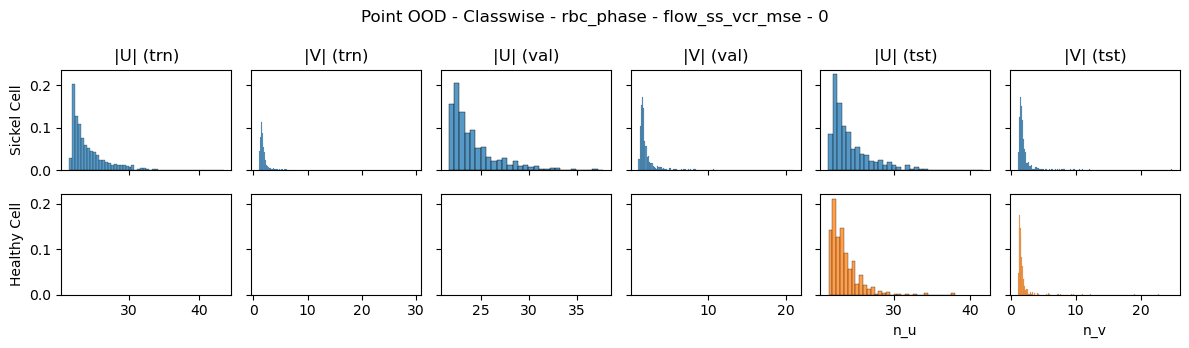

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

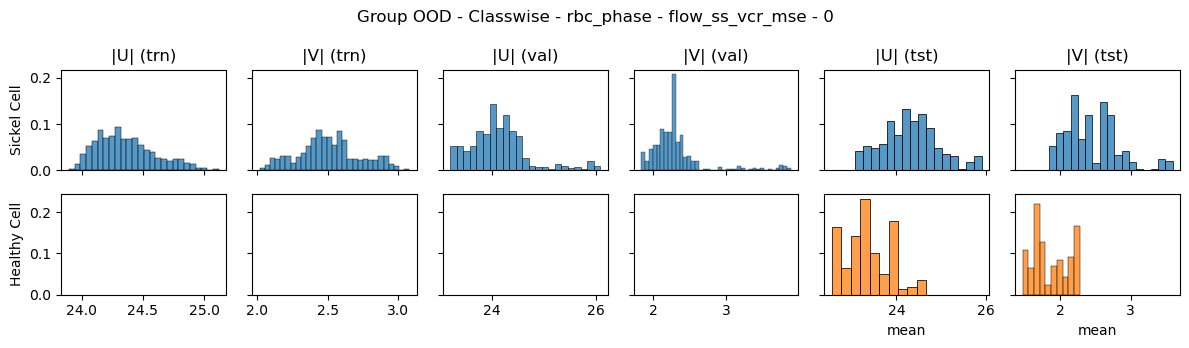

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

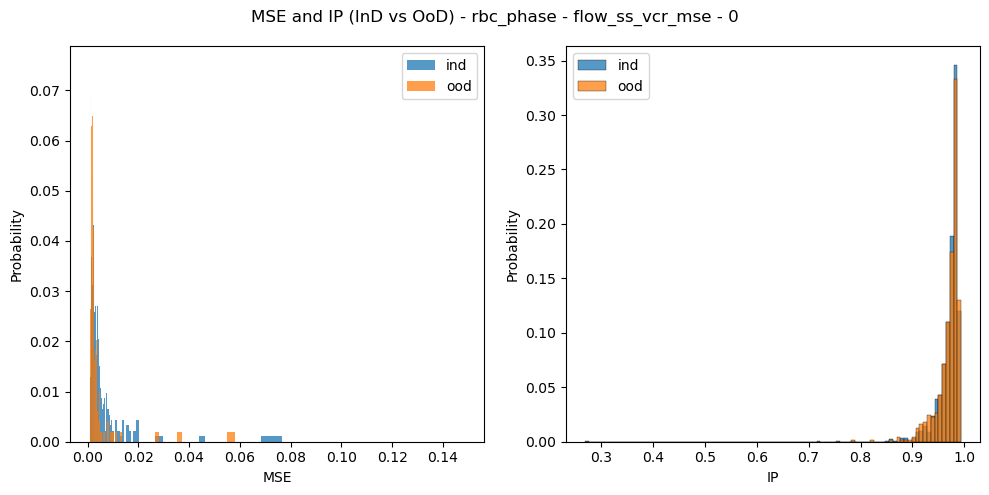

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()